<a href="https://colab.research.google.com/github/Rhayem1920/Stock-Price-Prediction/blob/main/Stock_Price_Prediction(Time_Series_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **I.Defining The Problem**
  In the supervised regression framework used for this case study, the weekly return of
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and incorporate as much information into the model. Out of correlated assets, technical indicators, and fundamental analysis (discussed in the section
before), we will focus on correlated assets as features in this case study. 


For this case study, **other than the historical data of Microsoft**, the independent variables used are the following potentially correlated assets:
**Stocks: IBM (IBM) and Alphabet (GOOGL)**


**Currency: USD/JPY and GBP/USD**


**Indices: S&P 500, Dow Jones, and VIX**

The dataset used for this case study is extracted from **Yahoo Finance and the FRED
website.**

In [ ]:
# Upload all Necessarily Libraries:

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

# rectifying visualistaion's parameters to have pretty plots
import matplotlib as mpl
font={'size': 14,
        'weight' : 'bold',
        'family':'monospace'} # weight could be book,bold etc ...
mpl.rc('font',**font)
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('lines',linewidth=5,c='black')
plt.rcParams["figure.figsize"] = (16,9)
sns.set_style('darkgrid')
# # saving visualisation function :
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join('/home/dhia/Pictures/', fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


**N.B:
Loading the data. One of the most important steps in machine learning and predictive modeling is gathering good data**


In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 14.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.65-py2.py3-none-any.whl size=25187 sha256=00cac903a5cdb7df5a65e400f584b3f6120c8c8034d86cb1bfe39994d3503125
  Stored in directory: /root/.cache/pip/wheels/cd/0a/a6/adb2a09bf4c1454abe9c042d9021b0eee9ce164c858e390cb6
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
stck_tickers=['MSFT','IBM','GOOGL']
ccy_tickers=['DEXJPUS','DEXUSUK']
idx_ticker=['SP500','DJIA','VIXCLS']

#stk_data=web.DataReader(stck_tickers,'yahoo')
import yfinance as yf
stk_data=yf.download(stck_tickers)
ccy_data=web.DataReader(ccy_tickers,'fred')
idx_data=web.DataReader(idx_ticker,'fred')


[*********************100%***********************]  3 of 3 completed


In [ ]:
#Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.
return_period=5




We now define our Y series and our X series

Y: MSFT Future Returns(the weekly return of MSFT)

X:

a. GOOGL 5 Business Day Returns

b. IBM 5 Business DayReturns    
c. USD/JPY 5 Business DayReturns    
d. GBP/USD 5 Business DayReturns    
e. S&P 500 5 Business DayReturns    
f. Dow Jones 5 Business DayReturns    
g. MSFT 5 Business Day Returns    
h. MSFT 15 Business Day Returns    
i. MSFT 30 Business Day Returns    
j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

**The variables used as independent variables are lagged five-day return of stocks (IBM
and GOOG), currencies (USD/JPY and GBP/USD), and indices (S&P 500, Dow
Jones, and VIX), along with lagged 5-day, 15-day, 30-day and 60-day return of
MSFT.
The lagged five-day variables embed the time series component by using a time-delay
approach, where the lagged variable is included as one of the independent variables.
This step is reframing the time series data into a supervised regression–based model
framework.**


In [ ]:
#Y is the weekly MSFT return
Y=np.log(stk_data.loc[:,('Adj Close','MSFT')]).diff(return_period).shift(-return_period)
Y.name=Y.name[-1]+'_pred'
#X1: the weekly return of stock of IBM and Google
X1=np.log(stk_data.loc[:,('Adj Close',('GOOGL','IBM'))]).diff(return_period)
X1.columns=X1.columns.droplevel()
# X2:the weekly stock return of currencies
X2=np.log(ccy_data).diff(return_period)
#X3: the weekly stock return of indices 
X3=np.log(idx_data).diff(return_period)
#X4: the MSFT multiple day return:(historical data for MSFT)
X4=pd.concat([np.log(stk_data.loc[:,('Adj Close','MSFT')]).diff(i*return_period) for i in [1,3,6,12]],axis=1).dropna()
X4.columns=['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']


In [ ]:
#X:
X=pd.concat([X1,X2,X3,X4],axis=1)
dataset=pd.concat([Y,X],axis=1).dropna().iloc[::return_period,:]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2016-11-21,0.003772,0.041072,0.028415,0.025706,0.000401,0.015579,0.004653,-0.153460,0.052799,0.022298,0.054176,0.054349
2016-11-29,-0.018837,0.005895,0.004658,0.016089,0.006498,0.000780,0.005124,0.038725,0.003772,0.017761,0.072177,0.064344
2016-12-07,0.021121,0.019894,0.015718,-0.007374,0.009807,0.019162,0.022034,-0.086943,0.018253,0.041589,0.012944,0.088882
2016-12-14,0.013627,0.032836,0.022323,0.013651,0.008060,0.005309,0.012349,0.076385,0.021121,0.025203,0.053770,0.105063
2016-12-21,-0.010123,-0.006981,-0.007027,0.023450,-0.028580,0.005267,0.007521,-0.157315,0.013627,0.053001,0.056255,0.098822


##**II.EDA:**

In [ ]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,236.000,236.000,2.360e+02,2.360e+02,2.360e+02,236.000,236.000,236.000,236.000,236.000,236.000,236.000
mean,0.007,0.006,9.333e-05,2.440e-04,6.001e-05,0.003,0.003,-0.005,0.008,0.021,0.042,0.084
std,0.028,0.033,3.426e-02,1.032e-02,1.266e-02,0.021,0.023,0.158,0.029,0.046,0.056,0.066
min,-0.120,-0.131,-1.569e-01,-3.572e-02,-7.346e-02,-0.131,-0.164,-0.384,-0.120,-0.149,-0.238,-0.116
25%,-0.008,-0.011,-1.508e-02,-4.924e-03,-6.811e-03,-0.003,-0.005,-0.091,-0.010,-0.004,0.014,0.047
50%,0.009,0.009,1.325e-03,5.049e-04,-3.285e-05,0.004,0.003,-0.017,0.010,0.025,0.045,0.079
75%,0.023,0.026,1.844e-02,5.613e-03,8.859e-03,0.013,0.012,0.060,0.025,0.049,0.075,0.127
max,0.077,0.089,9.202e-02,3.683e-02,5.530e-02,0.059,0.079,0.992,0.077,0.147,0.244,0.306


**The fastest way to learn more about the data is to visualize it.
The visualization involves independently understanding each attribute of the dataset.
We will look at the scatterplot and the correlation matrix. These plots give us a sense
of the interdependence of the data. Correlation can be calculated and displayed for
each pair of the variables by creating a correlation matrix. Hence, besides the rela‐
tionship between independent and dependent variables, it also shows the correlation
among the independent variables. This is useful to know because some machine
learning algorithms like linear and logistic regression can have poor performance if
there are highly correlated input variables in the data:**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c6f2b5e10>,
      dtype=object)

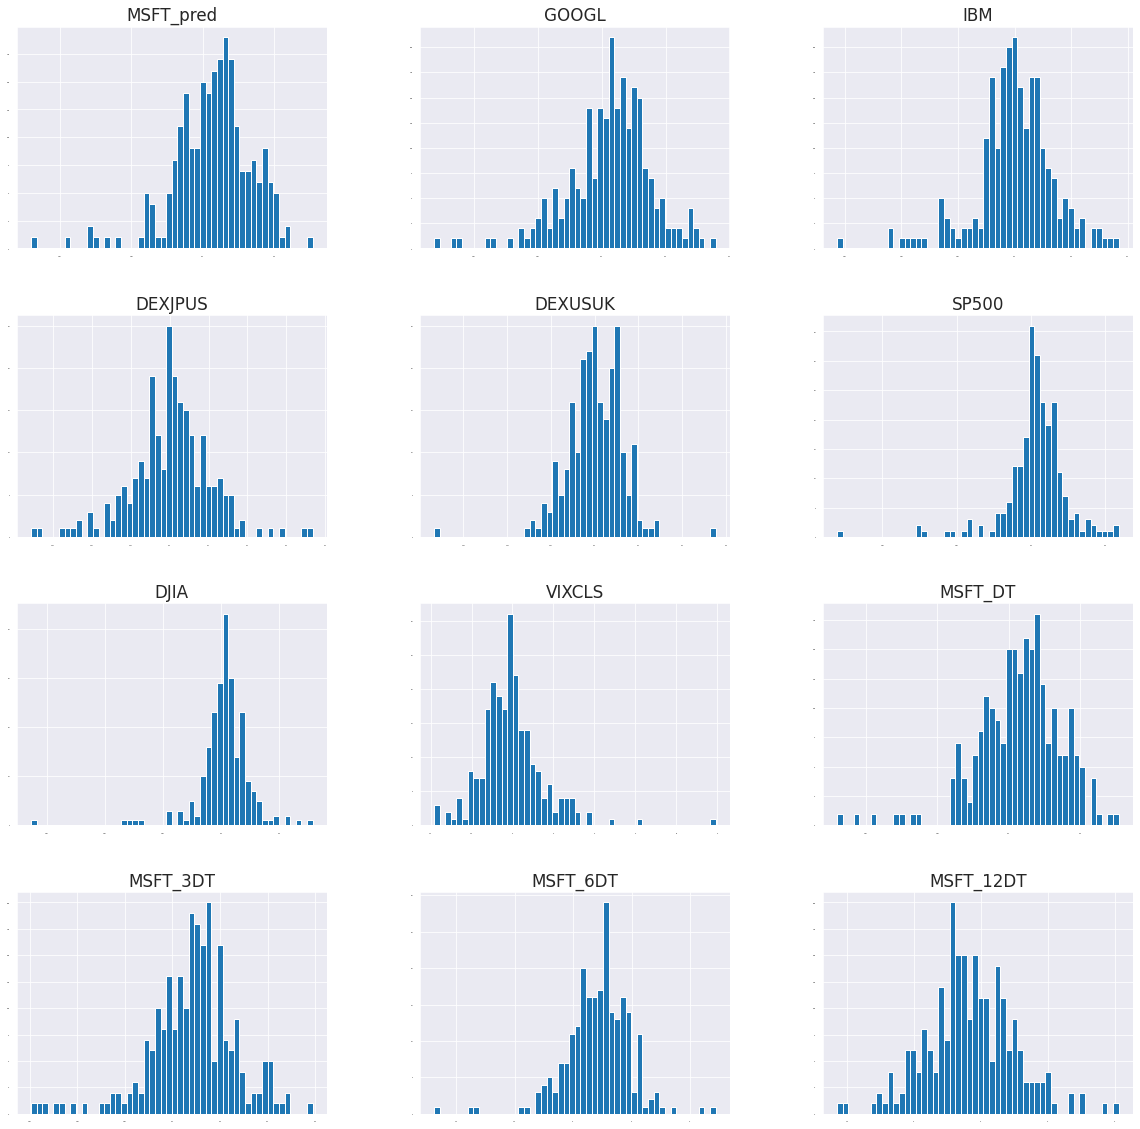

In [ ]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c6e1d4710>,
      dtype=object)

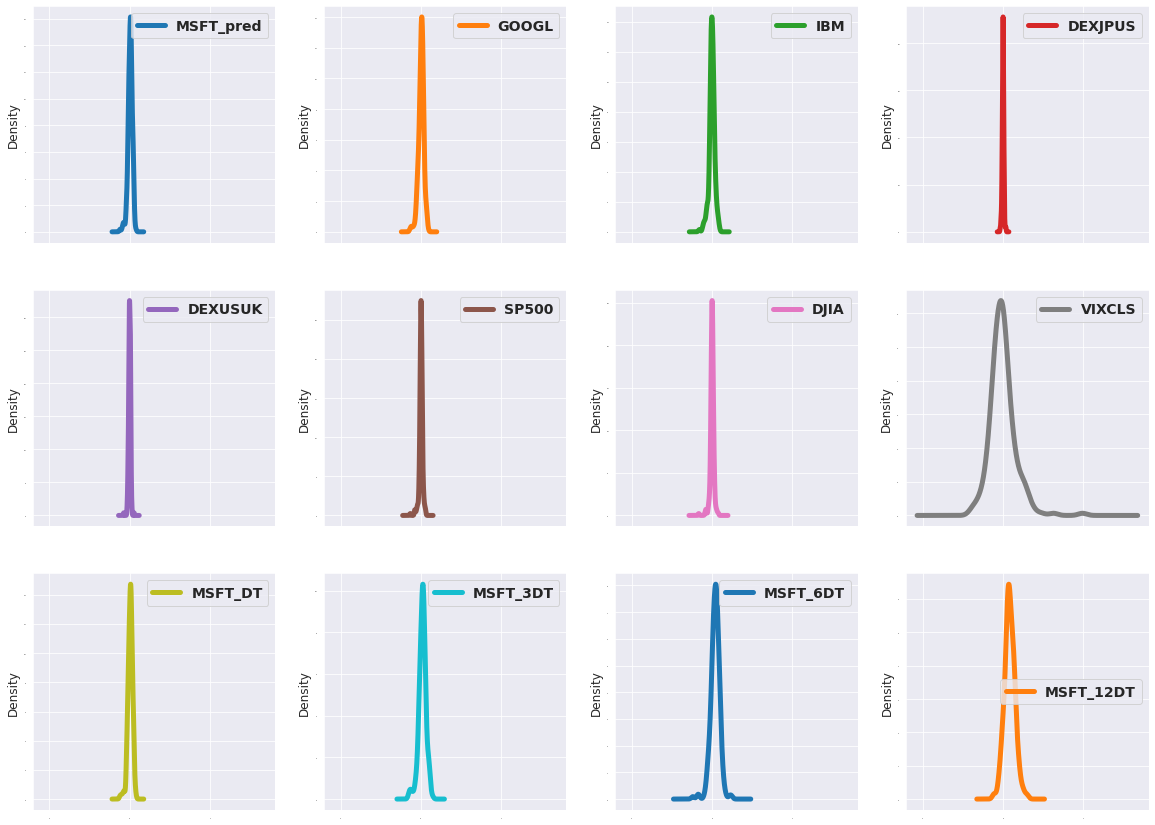

In [ ]:
# density plots:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(20,20))

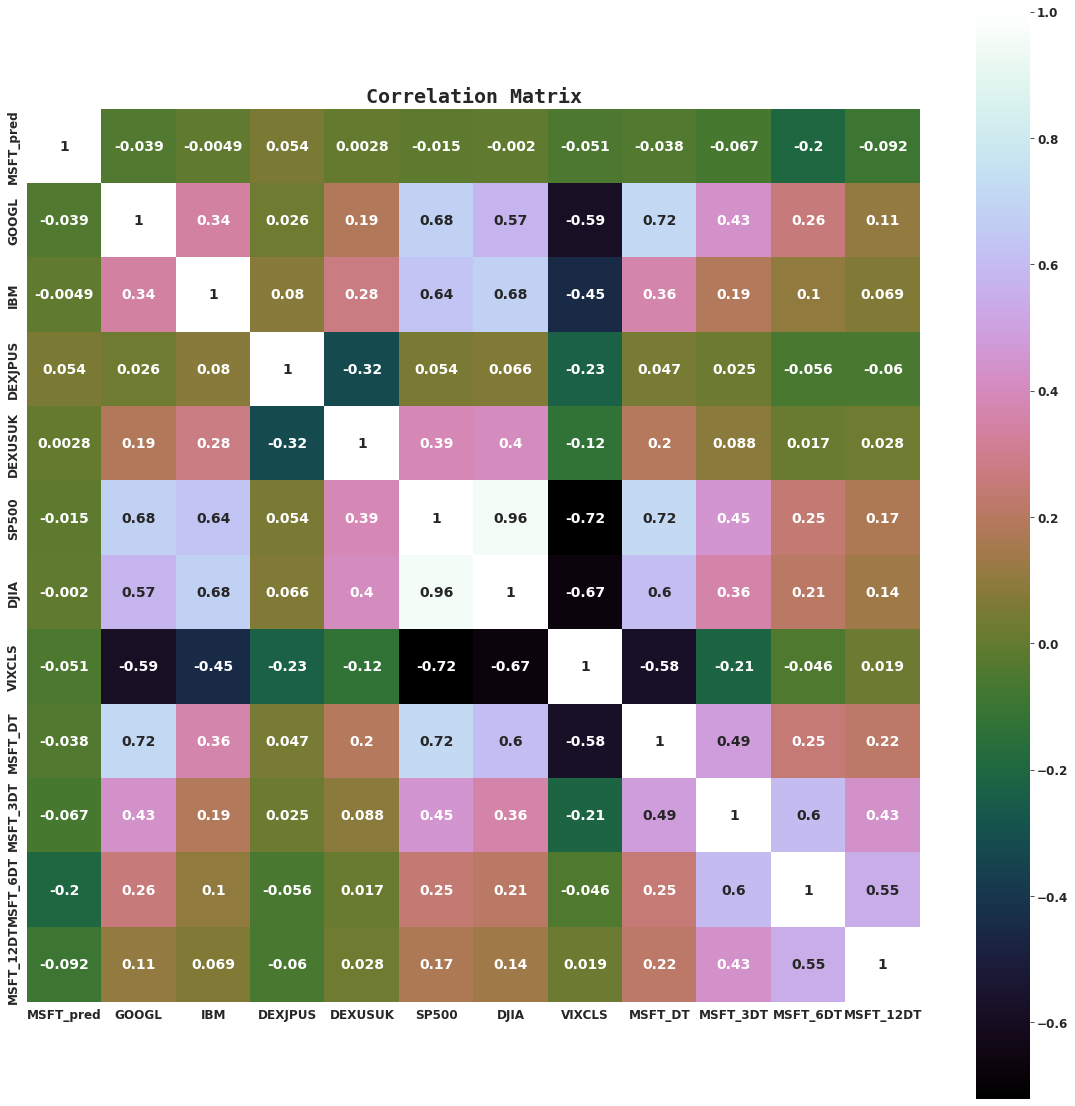

In [ ]:
# correlation matrix
plt.figure(figsize=(20,20))
correlations=dataset.corr()
plt.title('Correlation Matrix',fontdict=font,fontsize=20)
sns.heatmap(correlations,square=True,annot=True,cmap='cubehelix',vmax=1)


**we see some
correlation of the predicted variable with the lagged 5-day, 15-day, 30-day, and 60-
day returns of MSFT. Also, we see a higher negative correlation of many asset returns
versus VIX, which is intuitive.**


Next, we can visualize the relationship between all the variables in the regression
using the scatterplot matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c6c614790>,
      dtype=object)

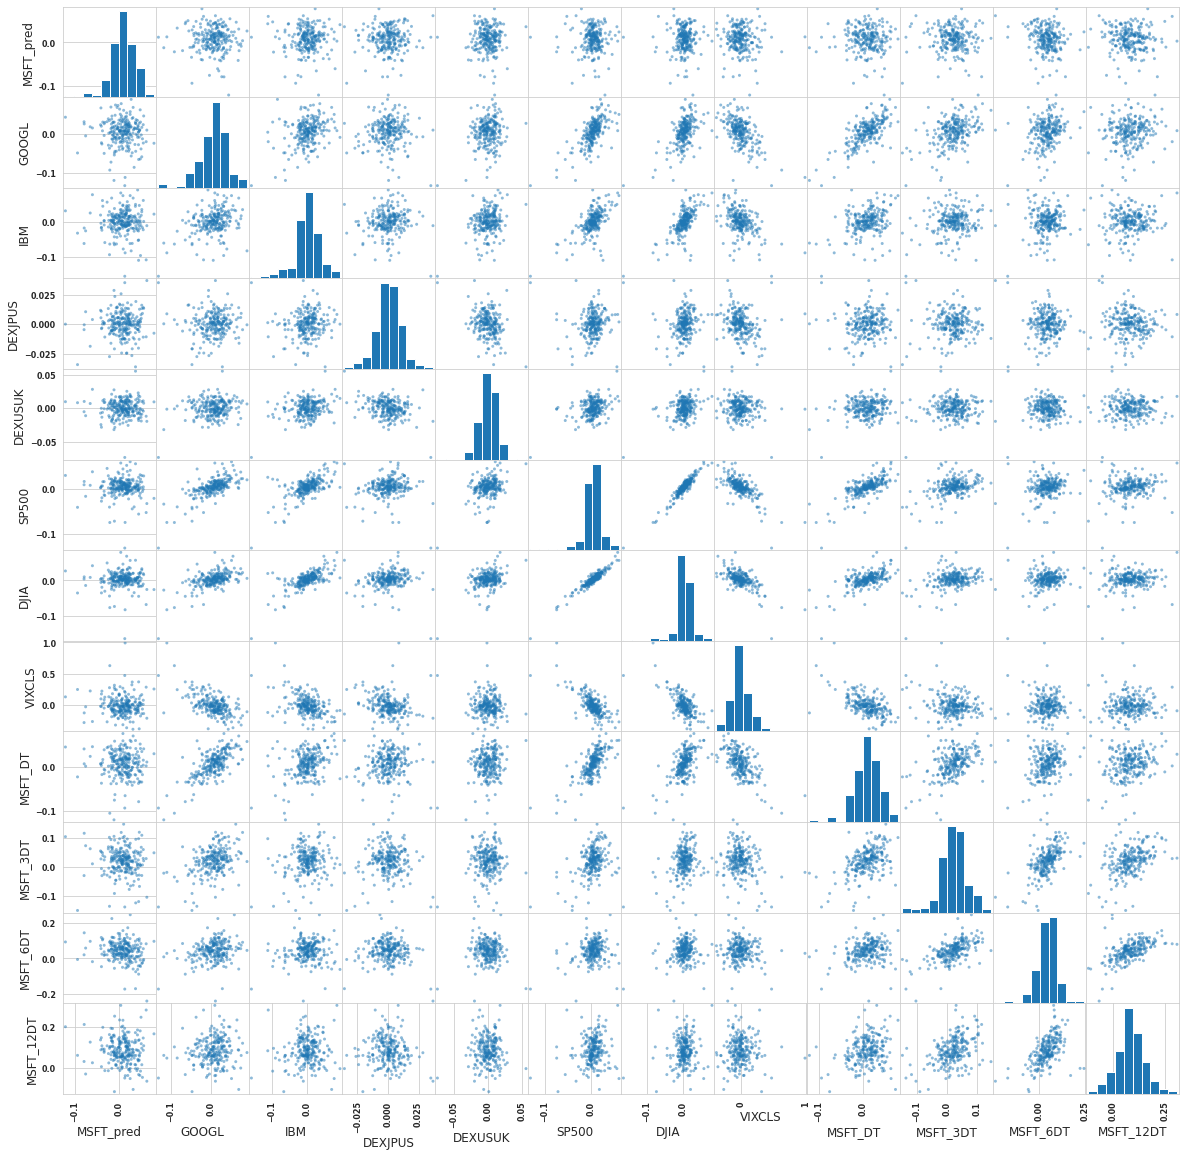

In [ ]:
sns.set_style('whitegrid')
scatter_matrix(dataset,figsize=(20,20))

**we see some linear
relationship of the predicted variable with the lagged 15-day, 30-day, and 60-day
returns of MSFT. Otherwise, we do not see any special relationship between our predicted variable and the features.**
##**III. Time Series Analysis**

Next, we delve into the time series analysis and look at the
decomposition of the time series of the predicted variable into trend and seasonality
components:

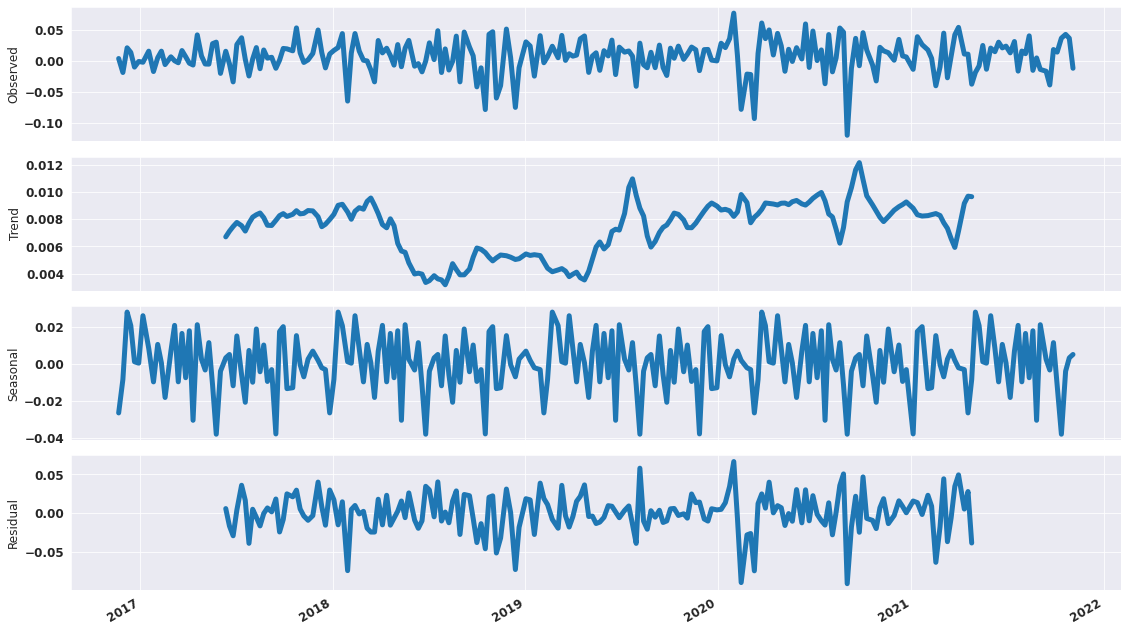

In [ ]:
ts=sm.tsa.seasonal_decompose(Y,freq=52)
sns.set_style('darkgrid')
ts.plot()
plt.show()

**We can see that for MSFT there has been a general upward trend in the return series.
This may be due to the large run-up of MSFT in the recent years, causing more positive weekly return data points than negative. 11 The trend may show up in the constant/bias terms in our models. The residual (or white noise) term is relatively small
over the entire time series.**

###4. Data Preparation

####**4.2. Feature Selection**

In [ ]:
best_features=SelectKBest(k=5,score_func=f_regression)
fit=best_features.fit(X,Y)
selection_scores=pd.DataFrame(fit.scores_)
features_scores=pd.concat([pd.DataFrame(X.columns),selection_scores],axis=1)
features_scores.columns=['Features','Score']
features_scores.nlargest(10,'Score').set_index('Features')  #print 10 best features
features_scores

,Features,Score
0,GOOGL,3.554e-01
1,IBM,5.615e-03
2,DEXJPUS,6.863e-01
3,DEXUSUK,1.886e-03
4,SP500,4.988e-02
5,DJIA,9.356e-04
6,VIXCLS,6.011e-01
7,MSFT_DT,3.352e-01
8,MSFT_3DT,1.041e+00
9,MSFT_6DT,1.003e+01


###**5. Evaluate Algorithms and Models**

####**5.1. Train Test Split and Evaluation Metrics**

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.
 

In [ ]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is  dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]


In [ ]:
#Test Options and Evaluation Metrics
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'



###**Choosing ML Models**
**1.Importing ALl ML and DL Models**

In [ ]:
models = []
#Regression and Tree Regression algorithms
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network Models:
models.append(('MLP', MLPRegressor()))
#Ensemble Learning Model:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

**2.Scoring ALL models using cross validation and mean squarred error(regression task)**

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000919 (0.000641) 0.000762 0.000592
LASSO: 0.000819 (0.000536) 0.000807 0.000549
EN: 0.000819 (0.000536) 0.000807 0.000549
KNN: 0.000931 (0.000492) 0.000640 0.000539
CART: 0.002028 (0.001726) 0.000000 0.001589
SVR: 0.001627 (0.000541) 0.001604 0.001533
MLP: 0.001922 (0.000733) 0.003337 0.002714
ABR: 0.000904 (0.000579) 0.000453 0.000815
GBR: 0.001159 (0.000982) 0.000078 0.000855
RFR: 0.001027 (0.000796) 0.000135 0.000781
ETR: 0.000930 (0.000609) 0.000000 0.000722


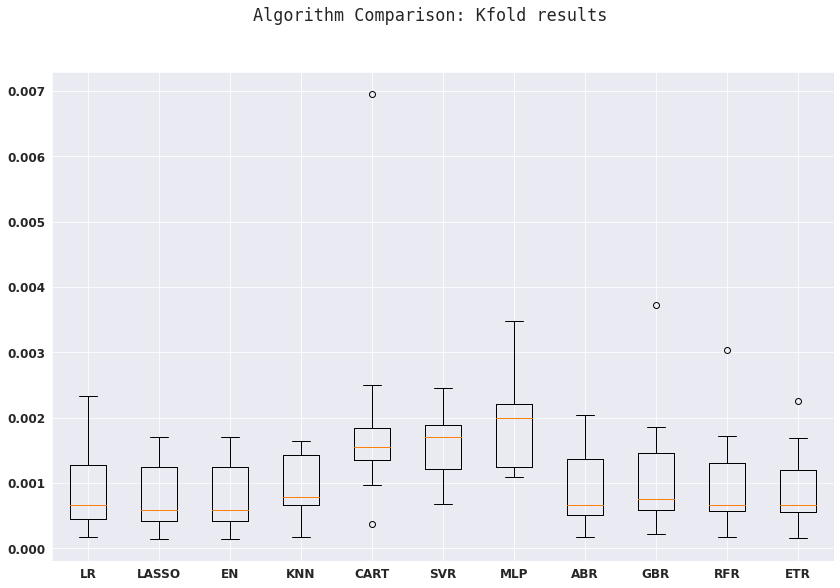

In [ ]:
#displaying kfold results:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results',fontdict=font)
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(14,9)

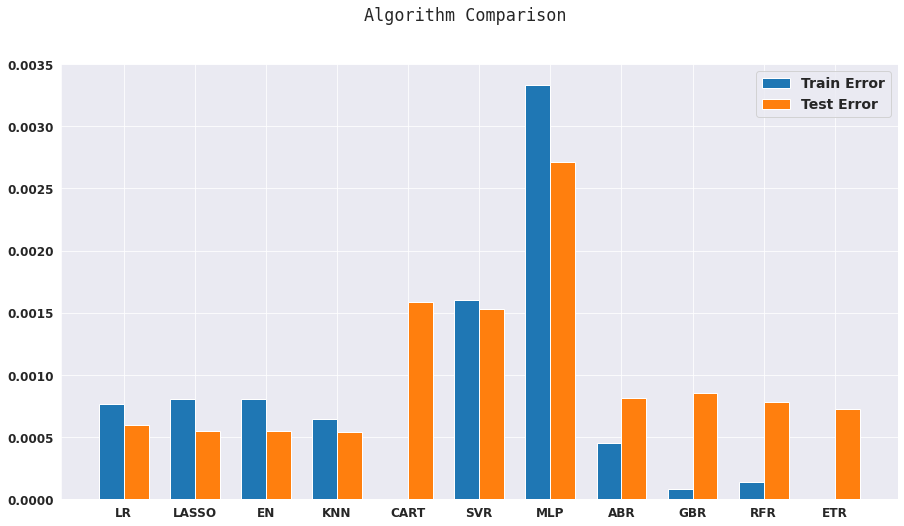

In [ ]:
#displaying Training and Test error
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison',fontdict=font)
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()


**Examining the training and test error, we still see a stronger performance from the
linear models. Some of the algorithms, such as the decision tree regressor (CART),
overfit on the training data and produced very high error on the test set. Ensemble
models such as gradient boosting regression (GBR) and random forest regression
(RFR) have low bias but high variance. We also see that the artificial neural network
algorithm (shown as MLP in the chart) shows higher errors in both the training and
test sets. This is perhaps due to the linear relationship of the variables not captured
accurately by ANN, improper hyperparameters, or insufficient training of the model.
Our original intuition from the cross validation results and the scatterplots also seem
to demonstrate a better performance of linear models.
We now look at some of the time series and deep learning models that can be used.
Once we are done creating these, we will compare their performance against that of
the supervised regression–based models. Due to the nature of time series models, we
are not able to run a k-fold analysis. We can still compare our results to the other
models based on the full training and testing results.**



###**5.3.1 Time Series based models-ARIMA and LSTM**

The models used so far already
embed the time series component by using a time-delay approach, where the lagged
variable is included as one of the independent variables. However, for the time series–based models we do not need the lagged variables of MSFT as the independent
variables. Hence, as a first step we remove MSFT’s previous returns for these models.
We use all other variables as the exogenous variables in these models.
Let us first prepare the dataset for ARIMA models by having only the correlated varriables as exogenous variables:




 **Time Series Model - ARIMA Model**

In [ ]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0006301563958360223

**Now let’s prepare the dataset for the LSTM model. We need the data in the form of
arrays of all the input variables and the output variables.
The logic behind the LSTM is that data is taken from the previous day (the data of all
the other features for that day—correlated assets and the lagged variables of MSFT)
and we try to predict the next day. Then we move the one-day window with one day
and again predict the next day. We iterate like this over the whole dataset (of course
in batches). The code below will create a dataset in which X is the set of independent
variables at a given time (t) and Y is the target variable at the next time (t + 1):**

#### **LSTM**:

In [ ]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)



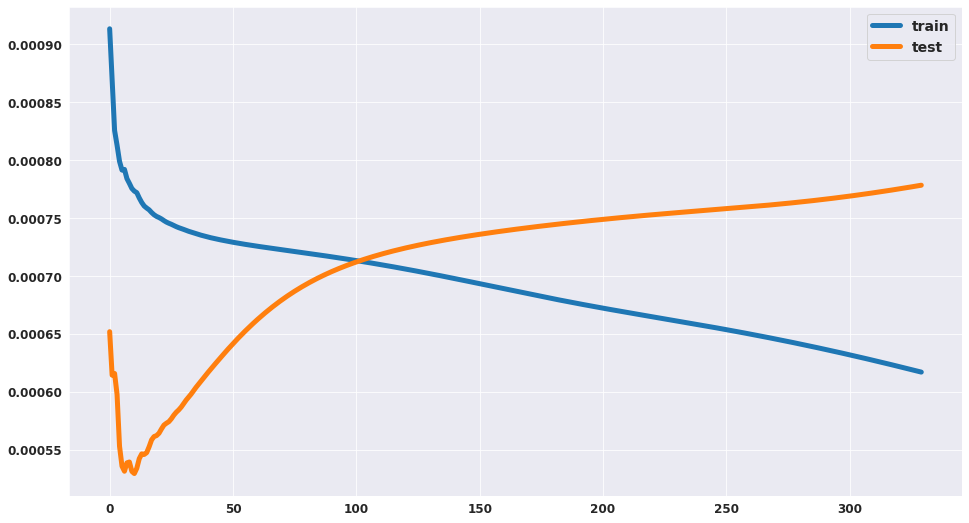

In [ ]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
L=['dhia','joue','au','ballon']
print(' '.join(L))

dhia joue au ballon


In [ ]:
import numpy as np
ch=np.nan 
ch

nan